In [1]:
!pip install pandas
!pip install numpy
!pip install fix-yahoo-finance

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import itertools

In [2]:
# The following is an algorithm based on the Bollinger Bands Squeeze theory
# The theory takes advantage of the recurring pattern in volatile securities where:
# It predicts that as the standard deviation falls (Bollinger Bands Squeezes), it tends to expand again
# Hence, it is a good alternative predictor of breakouts
# To identify the direction of the breakout, the strategy measures the price change on the day

# Download data from Yahoo Finance
tickers = ['^GSPC']

In [3]:
# Note the strategy is designed to perform in period of volatile market downturn
data = yf.download(
    tickers=tickers,
    start="2022-01-01",
    end="2022-12-31",
    interval="1d",
    auto_adjust=True
)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Ensure 'data' is a simple DataFrame with just the 'Close' column
data = pd.DataFrame(data['Close']).dropna()
data.columns = ['Close']

# Initial capital
initial_capital = 4000

In [5]:
# Define parameter ranges for optimisation (Below figures are tested using trial and error on TradingView)
# Concluded that these ranges provide the best outcome for this strategy
# The code below optimises the Sharpe Ratio base on numbers in these ranges using grid search
length_values = [5, 10, 15, 20, 25]  # Different lengths for Bollinger Bands
mult_values = [1.5, 2.0, 2.5]  # Different multipliers for standard deviation
cond_values = [0.02, 0.03, 0.04, 0.05, 0.07, 0.1]  # Different BBW thresholds
BOlength_values = [3, 5, 10]  # Different breakout lengths

# Variables to store the best parameters and Sharpe ratio
best_params = None
best_sharpe_ratio = -float('inf')

In [6]:
# Function to backtest the strategy
def backtest_strategy(length, mult, cond, BOlength):
    capital = initial_capital
    position = 0  # -1 for short, 0 for no position, 1 for long
    capital_history = [initial_capital]
    buy_signals = []
    sell_signals = []
    trailing_stop_price = None
    stop_percent = 0.03

    # Calculate Bollinger Bands
    data['SMA'] = data['Close'].rolling(window=length).mean()
    data['StdDev'] = data['Close'].rolling(window=length).std()
    data['Upper'] = data['SMA'] + (mult * data['StdDev'])
    data['Lower'] = data['SMA'] - (mult * data['StdDev'])
    data['BBW'] = (data['Upper'] - data['Lower']) / data['SMA']

    # Entry and exit conditions with one-day lag
    data['BuyEntry'] = ((data['BBW'] > cond) & (data['Close'] > data['Close'].shift(BOlength))).shift(1).astype(bool)
    data['SellEntry'] = ((data['BBW'] > cond) & (data['Close'] < data['Close'].shift(BOlength))).shift(1).astype(bool)

    # Calculate daily returns
    data['Returns'] = data['Close'].pct_change().fillna(0)

    # Trading simulation
    for index, row in data.iterrows():
    # Apply return first based on current position
        if position != 0:
            capital *= (1 + position * row['Returns'])
        capital_history.append(capital)

        # Flip logic
        if position == 0:
            if row['BuyEntry']:
                position = 1
                trailing_stop_price = row['Close'] * (1 - stop_percent)
                buy_signals.append(index)
            elif row['SellEntry']:
                position = -1
                trailing_stop_price = row['Close'] * (1 + stop_percent)
                sell_signals.append(index)

        elif position == 1:
            if row['Close'] > trailing_stop_price / (1 - stop_percent):
                trailing_stop_price = row['Close'] * (1 - stop_percent)
            if row['SellEntry'] or row['Close'] <= trailing_stop_price:
                # Exit long, go short
                position = -1
                trailing_stop_price = row['Close'] * (1 + stop_percent)
                sell_signals.append(index)

        elif position == -1:
            if row['Close'] < trailing_stop_price / (1 + stop_percent):
                trailing_stop_price = row['Close'] * (1 + stop_percent)
            if row['BuyEntry'] or row['Close'] >= trailing_stop_price:
                # Exit short, go long
                position = 1
                trailing_stop_price = row['Close'] * (1 - stop_percent)
                buy_signals.append(index)




    # Calculate daily returns and Sharpe ratio
    capital_series = pd.Series(capital_history)
    daily_returns = capital_series.pct_change().dropna()
    avg_return = daily_returns.mean()
    std_return = daily_returns.std()

    # Calculate Sharpe Ratio
    if std_return != 0:
        sharpe_ratio = avg_return / std_return
    else:
        sharpe_ratio = -float('inf')  # Avoid division by zero

    return sharpe_ratio, buy_signals, sell_signals, capital_history

In [7]:
# Function to find the best condition and BO length
def optimize_cond_and_BOlength(length, mult):
    global best_sharpe_ratio, best_params
    for cond, BOlength in itertools.product(cond_values, BOlength_values):
        sharpe_ratio, _, _, _ = backtest_strategy(length, mult, cond, BOlength)
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_params = (length, mult, cond, BOlength)

# Grid search over all length and mult parameter combinations
for length, mult in itertools.product(length_values, mult_values):
    optimize_cond_and_BOlength(length, mult)

# Output the best parameters
print(f"Best Parameters: Length={best_params[0]}, Mult={best_params[1]}, Cond={best_params[2]}, BOlength={best_params[3]}")
print(f"Best Sharpe Ratio: {round(best_sharpe_ratio,2)}")

Best Parameters: Length=5, Mult=1.5, Cond=0.04, BOlength=10
Best Sharpe Ratio: 0.07


In [8]:
# Re-run the strategy with the best parameters
length, mult, cond, BOlength = best_params
_, buy_signals, sell_signals, capital_history = backtest_strategy(length, mult, cond, BOlength)

# Convert buy_signals and sell_signals to lists of indices
buy_signals = [data.index.get_loc(signal) for signal in buy_signals if signal in data.index]
sell_signals = [data.index.get_loc(signal) for signal in sell_signals if signal in data.index]

# Calculate returns
data['Capital'] = capital_history[:len(data)]
data['BuyHold'] = initial_capital * (data['Close'] / data['Close'].iloc[0])

Sortino Ratio: 0.12


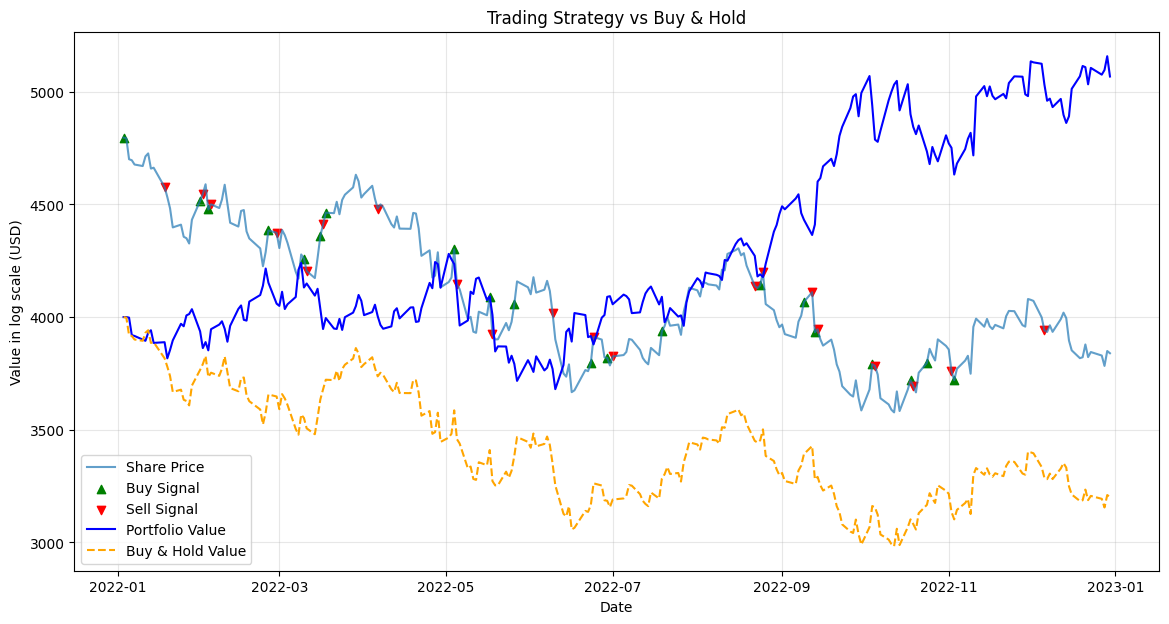


Final Portfolio Value: $5,067.61
Final Buy & Hold Value: $3,201.88
Strategy Return: 26.69%
Buy & Hold Return: -19.95%
Outperformance: 46.64%


In [9]:
##########Performance Evaluation############
capital_series = pd.Series(capital_history)
daily_returns = capital_series.pct_change().dropna()
avg_return = daily_returns.mean()
std_return = daily_returns.std()

# Sortino Ratio
def calculate_sortino_ratio(returns, target=0):
    downside_returns = returns[returns < target]
    downside_deviation = downside_returns.std()
    avg_return = returns.mean()
    
    if downside_deviation != 0:
        sortino_ratio = avg_return / downside_deviation
    else:
        sortino_ratio = -float('inf')  # Avoid division by zero
    
    return sortino_ratio

sortino_ratio = calculate_sortino_ratio(daily_returns)

print(f"Sortino Ratio: {round(sortino_ratio ,2)}")

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Share Price', alpha=0.7)
plt.scatter(data.index[buy_signals], data['Close'].iloc[buy_signals], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(data.index[sell_signals], data['Close'].iloc[sell_signals], label='Sell Signal', marker='v', color='red', alpha=1)
plt.plot(data.index, data['Capital'], label='Portfolio Value', color='blue')
plt.plot(data.index, data['BuyHold'], label='Buy & Hold Value', color='orange', linestyle='--')
plt.legend()
plt.title("Trading Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Value in log scale (USD)")
plt.grid(visible=True, alpha=0.3)
plt.show()

# Final values
final_portfolio_value = data['Capital'].iloc[-1]
final_buy_hold_value = data['BuyHold'].iloc[-1]

# Total returns
strategy_return = (final_portfolio_value / initial_capital - 1) * 100
buy_hold_return = (final_buy_hold_value / initial_capital - 1) * 100
outperformance = strategy_return - buy_hold_return

# Display
print(f"\nFinal Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Final Buy & Hold Value: ${final_buy_hold_value:,.2f}")
print(f"Strategy Return: {strategy_return:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"Outperformance: {outperformance:.2f}%")